# 循环神经网络
* 循环神经网络的输出取决于当下输入和前一时间的隐变量
* 应用到语言模型中时，根据当前词和之前看过的词预测下一次时刻词
## 有隐状态的循环神经网络
$$\mathbf{H}_t = \phi(\mathbf{X}_t \mathbf{W}_{xh} + \mathbf{H}_{t-1} \mathbf{W}_{hh}  + \mathbf{b}_h).$$

$$\mathbf{O}_t = \mathbf{H}_t \mathbf{W}_{hq} + \mathbf{b}_q.$$
## 字符级语言模型
![基于循环神经网络的字符级语言模型：输入序列和标签序列分别为“machin”和“achine”](../img/rnn-train.svg)

## 困惑度（Perplexity）
平均交叉熵的指数
$$\exp\left(-\frac{1}{n} \sum_{t=1}^n \log P(x_t \mid x_{t-1}, \ldots, x_1)\right).$$


文本生成、文本分类、机器翻译

In [32]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from g2fl import dl as dl

batch_size, num_steps = 32, 35
train_iter, vocab = dl.load_data_time_machine(batch_size, num_steps)

独热编码

In [33]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

小批量数据形状是二维张量： （批量大小，时间步数）

In [34]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

初始化循环神经网络模型的模型参数

In [35]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device) * 0.01

    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [36]:
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

In [37]:
def rnn(inputs, state, params):
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

In [38]:
class RNNModelScratch: 
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [39]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, dl.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], dl.try_gpu())
Y, new_state = net(X.to(dl.try_gpu()), state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

In [20]:
def predict_rnn(prefix, num_preds, net, vocab, device):  
    """在prefix后面生成新字符"""
    state = net.begin_state(batch_size=1, device=device)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))
    for y in prefix[1:]:
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_preds):
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

predict_rnn('time traveller ', 10, net, vocab, dl.try_gpu())

'time traveller nvijpwzvfs'

In [21]:
def grad_clipping(net, theta):  
    """裁剪梯度，避免梯度爆炸"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

In [26]:
for X, Y in train_iter:
    print(Y.shape)
    print(Y.T.reshape(-1).shape)
    break

torch.Size([32, 35])
torch.Size([1120])


In [28]:
def train_epoch_rnn(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期（定义见第8章）"""
    state, timer = None, dl.Timer()
    metric = dl.Accumulator(2)
    for X, Y in train_iter:
        if state is None or use_random_iter:
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                state.detach_()
            else:
                for s in state:
                    s.detach_()
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            updater(batch_size=1)
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [29]:
def train_rnn(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）"""
    loss = nn.CrossEntropyLoss()
    animator = dl.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: dl.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_rnn(prefix, 50, net, vocab, device)
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_rnn(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            # print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

困惑度 1.0, 69787.7 词元/秒 cuda:0
time traveller after the pauserequired for the proper assimilati
traveller with a slight accession ofcheerfulness really thi


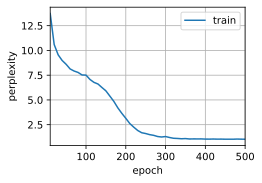

In [30]:
num_epochs, lr = 500, 1
train_rnn(net, train_iter, vocab, lr, num_epochs, dl.try_gpu())

困惑度 1.5, 68949.6 词元/秒 cuda:0
time travellerit s against reason said filby of course a solid b
travellerit s against reason said filby of course a solid b


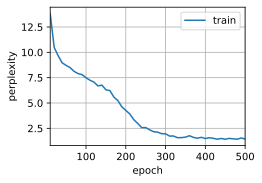

In [31]:
net = RNNModelScratch(len(vocab), num_hiddens, dl.try_gpu(), get_params,
                      init_rnn_state, rnn)
train_rnn(net, train_iter, vocab, lr, num_epochs, dl.try_gpu(),
          use_random_iter=True)